# Лабораторная работа 1 — ноутбук

Интерактивно исследуем предобработку, моделирование и контроль дрейфа на различных датасетах. Поменяйте `DATASET_ID`, чтобы переключаться между Titanic и Iris.

In [1]:
import sys
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image, display

warnings.filterwarnings("ignore")

sys.path.append(str(Path.cwd()))
import lab1

FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)

print("lab1 модуль загружен; ноутбук готов.")

lab1 модуль загружен; ноутбук готов.


## Обзор данных

Выберите набор (`DATASET_ID`) и при необходимости лимит строк (`MAX_ROWS`), затем загрузим таблицу и посмотрим первые записи и статистику.

In [2]:
DATASET_ID = '1'  # Поменяйте на '2' или '3'
MAX_ROWS = None  # или целое число, например 2000 None
config = lab1.get_dataset_config(DATASET_ID)
df = lab1.load_dataset(config, max_rows=MAX_ROWS)
print(f"Используем датасет {config['name']} (ID {DATASET_ID}): {config['description']}")
print("Размер таблицы:", df.shape)
display(df.head())
display(df.describe(include="all").T)

Используем датасет Titanic (ID 1): Passengers and survival outcome
Размер таблицы: (891, 12)


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
passengerid,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


## Сравнение классификации и регрессии

Пробуем все сочетания импутеров, фильтров выбросов и скейлеров, затем выводим топовые комбинации.

In [3]:
# Собираем результаты классификации
classification_results = []
for outlier in lab1.OUTLIER_METHODS:
    for imputer in lab1.MISSING_STRATEGIES:
        for scaler in lab1.SCALING_METHODS:
            classification_results.append(
                lab1.evaluate_classification(df, config, outlier, imputer, scaler)
            )
classification_df = pd.DataFrame(classification_results)
classification_table = (
    classification_df
    .sort_values("Accuracy", ascending=False)
    .round({"Accuracy": 3, "Precision": 3, "Recall": 3, "F1": 3, "SampleCount": 0, "FoldCount": 0})
)
# Показываем лучшие пять вариантов
display(classification_table.head(5))

,Outlier,Imputer,Scaler,Accuracy,Precision,Recall,F1,SampleCount,FoldCount
54,winsorization,knn,none,0.804,0.803,0.804,0.801,891,5
76,winsorization,iterative,quantile,0.804,0.803,0.804,0.802,891,5
91,log,median,standard,0.802,0.802,0.802,0.801,891,5
12,none,knn,none,0.801,0.800,0.801,0.799,891,5
58,winsorization,knn,quantile,0.801,0.800,0.801,0.800,891,5


In [4]:
# Собираем результаты регрессии
regression_data = df[config['regression_features'] + [config['regression_target']]].dropna(subset=[config['regression_target']])
regression_results = []
for outlier in lab1.OUTLIER_METHODS:
    for imputer in lab1.MISSING_STRATEGIES:
        for scaler in lab1.SCALING_METHODS:
            regression_results.append(
                lab1.evaluate_regression(regression_data, config, outlier, imputer, scaler)
            )
regression_df = pd.DataFrame(regression_results)
regression_table = (
    regression_df
    .sort_values("RMSE", ascending=True)
    .round({"RMSE": 3, "MSE": 3, "MAE": 3, "R2": 3, "SampleCount": 0, "FoldCount": 0})
)
# Показываем лучшие пять вариантов
display(regression_table.head(5))

,Outlier,Imputer,Scaler,RMSE,MSE,MAE,R2,SampleCount,FoldCount
102,log,most_frequent,none,35.784,1470.098,13.486,0.421,891,5
105,log,most_frequent,robust,35.784,1470.103,13.488,0.421,891,5
192,yeojohnson,constant_zero,none,35.786,1473.457,13.542,0.419,891,5
193,yeojohnson,constant_zero,standard,35.786,1473.457,13.542,0.419,891,5
194,yeojohnson,constant_zero,minmax,35.786,1473.457,13.542,0.419,891,5


## Полная статистика

Сохраняем и отображаем все результаты, чтобы можно было сравнить разные комбинации.

In [5]:
# Сохраняем полную статистику и показываем таблицы
classification_path = lab1.RESULTS_DIR / f"classification_full_{DATASET_ID}.csv"
regression_path = lab1.RESULTS_DIR / f"regression_full_{DATASET_ID}.csv"
lab1.ensure_results_dir()
classification_df.to_csv(classification_path, index=False)
regression_df.to_csv(regression_path, index=False)
print("Файлы с полной статистикой:")
print("  ", classification_path)
print("  ", regression_path)
display(classification_df.sort_values("Accuracy", ascending=False))
display(regression_df.sort_values("RMSE", ascending=True))

Файлы с полной статистикой:
   /home/user/Documents/LABS_MAGA/Methods_for_processing_and_analyzing_heterogeneous_data/Lab1/results/classification_full_1.csv
   /home/user/Documents/LABS_MAGA/Methods_for_processing_and_analyzing_heterogeneous_data/Lab1/results/regression_full_1.csv


,Outlier,Imputer,Scaler,Accuracy,Precision,Recall,F1,SampleCount,FoldCount
54,winsorization,knn,none,0.803603,0.803035,0.803603,0.801265,891,5
76,winsorization,iterative,quantile,0.803597,0.803080,0.803597,0.802450,891,5
91,log,median,standard,0.802473,0.802341,0.802473,0.801494,891,5
12,none,knn,none,0.801362,0.800276,0.801362,0.799243,891,5
58,winsorization,knn,quantile,0.801362,0.800274,0.801362,0.799823,891,5
...,...,...,...,...,...,...,...,...,...
111,log,constant_zero,robust,0.774415,0.776789,0.774415,0.774032,891,5
28,none,constant_zero,quantile,0.774415,0.775933,0.774415,0.774320,891,5
109,log,constant_zero,standard,0.774415,0.776789,0.774415,0.774032,891,5
41,none,drop,unit_vector,0.773791,0.773789,0.773791,0.771748,712,5


,Outlier,Imputer,Scaler,RMSE,MSE,MAE,R2,SampleCount,FoldCount
102,log,most_frequent,none,35.783828,1470.098053,13.486423,0.421055,891,5
105,log,most_frequent,robust,35.783872,1470.103478,13.487872,0.421054,891,5
192,yeojohnson,constant_zero,none,35.785947,1473.457041,13.541719,0.418542,891,5
193,yeojohnson,constant_zero,standard,35.785947,1473.457041,13.541719,0.418542,891,5
194,yeojohnson,constant_zero,minmax,35.785947,1473.457041,13.541719,0.418542,891,5
...,...,...,...,...,...,...,...,...,...
38,none,drop,minmax,40.560968,1791.983921,14.959932,0.293451,712,5
39,none,drop,robust,40.566369,1792.186554,14.923220,0.292910,712,5
41,none,drop,unit_vector,40.815471,1808.517369,16.822855,0.299560,712,5
167,boxcox,drop,unit_vector,41.561783,1883.912368,15.190809,0.231606,712,5


## Диагностика дрейфа

Сравниваем распределения двух стратифицированных подвыборок по числовым признакам.

In [6]:
# Формируем эталонную и контрольную выборку
drift_df = df.dropna(subset=[config['classification_target']])
allowed = config.get('classification_allowed_values')
if allowed:
    drift_df = drift_df[drift_df[config['classification_target']].isin(allowed)]
if drift_df.shape[0] < 2 or drift_df[config['classification_target']].nunique() < 2:
    print('Недостаточно данных для оценки дрейфа.')
    drift_report = pd.DataFrame([{'feature': col, 'p_value': float('nan'), 'drift': False, 'note': 'not enough samples'} for col in config['classification_numeric']])
else:
    reference, current = lab1.train_test_split(
        drift_df,
        test_size=0.5,
        stratify=drift_df[config['classification_target']],
        random_state=42,
    )
    drift_report = lab1.detect_drift(reference, current, config['classification_numeric'])
# Отображаем p-значения и вывод
display(drift_report)
print('Дрейф обнаружен?', 'Да (p < 0.05)' if drift_report['drift'].any() else 'Нет (все p >= 0.05)')

,feature,p_value,drift,note
1,age,0.299135,False,
2,sibsp,0.622274,False,
4,fare,0.632219,False,
3,parch,0.987737,False,
0,pclass,1.000000,False,


Дрейф обнаружен? Нет (все p >= 0.05)


In [7]:
# Смотрим лучшие пайплайны
best_class = classification_table.iloc[0]
best_reg = regression_table.iloc[0]

# Вычисление confusion matrix для лучшей модели классификации
best_outlier = best_class['Outlier']
best_imputer = best_class['Imputer']
best_scaler = best_class['Scaler']

prepared = lab1.apply_drop_strategy(df, config["classification_numeric"] + config["classification_categorical"], [config["classification_target"]], best_imputer)
filtered = lab1.detect_outliers(prepared, config["classification_numeric"], method=best_outlier)
filtered = filtered.dropna(subset=[config["classification_target"]])
allowed = config.get("classification_allowed_values")
if allowed:
    filtered = filtered[filtered[config["classification_target"]].isin(allowed)]

X_best = filtered[config["classification_features"]]
y_best = filtered[config["classification_target"]]

numeric_imputer = lab1.get_numeric_imputer(best_imputer)
scaler = lab1.get_scaler(best_scaler)
pipeline_best = lab1.build_preprocessing_pipeline(
    config["classification_numeric"],
    config["classification_categorical"],
    numeric_imputer,
    scaler,
    lab1.build_classification_estimator(False),  # CPU version
)

# Обучаем на всех данных и получаем предсказания
pipeline_best.fit(X_best, y_best)
y_pred = pipeline_best.predict(X_best)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_best, y_pred)

print("Лучший классификационный пайплайн:", best_class[["Imputer", "Outlier", "Scaler", "Accuracy"]].to_dict())
print("Confusion Matrix для лучшей модели классификации:")
print(cm)
print("\nЛучший регрессионный пайплайн:", best_reg[["Imputer", "Outlier", "Scaler", "RMSE", "MSE"]].to_dict())

Лучший классификационный пайплайн: {'Imputer': 'knn', 'Outlier': 'winsorization', 'Scaler': 'none', 'Accuracy': 0.804}
Confusion Matrix для лучшей модели классификации:
[[475  74]
 [104 238]]

Лучший регрессионный пайплайн: {'Imputer': 'most_frequent', 'Outlier': 'log', 'Scaler': 'none', 'RMSE': 35.784, 'MSE': 1470.098}


## Визуализации

Повторно строим графики, отображаем их и объясняем, что показывает каждый из них.

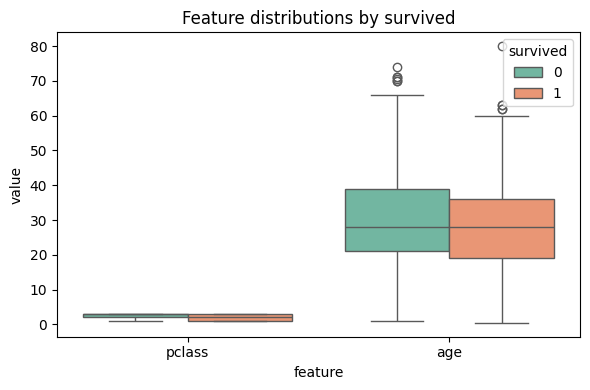

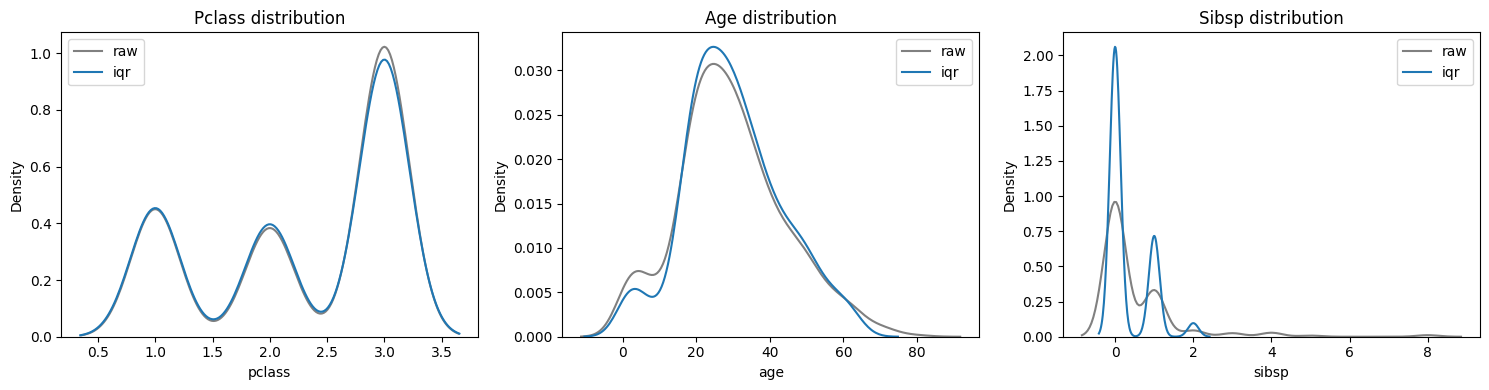

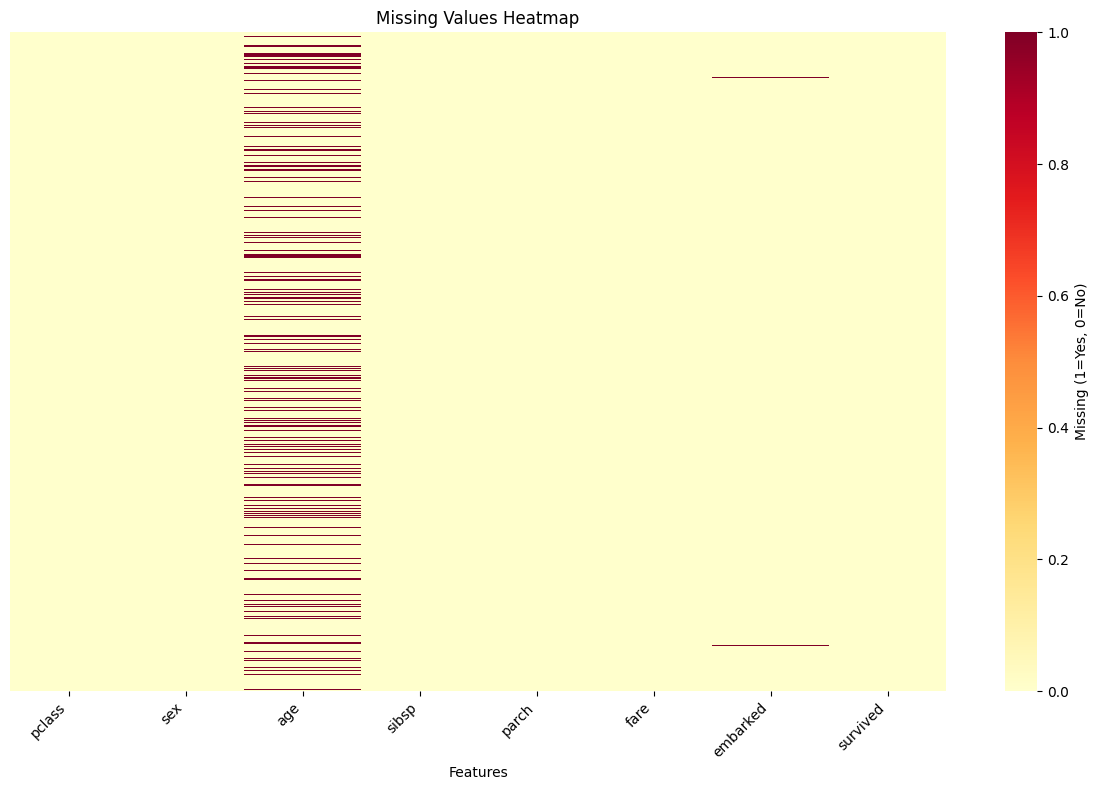

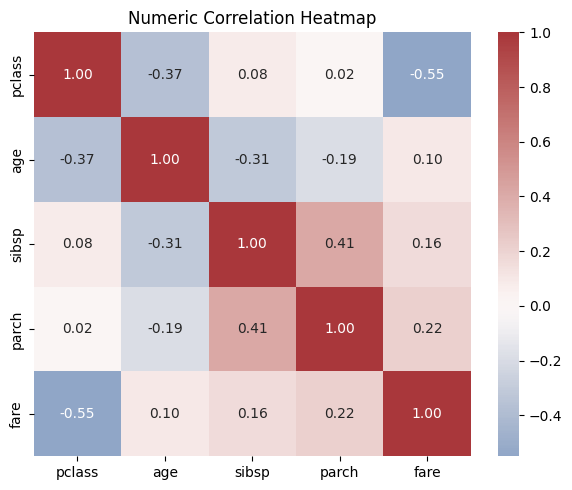

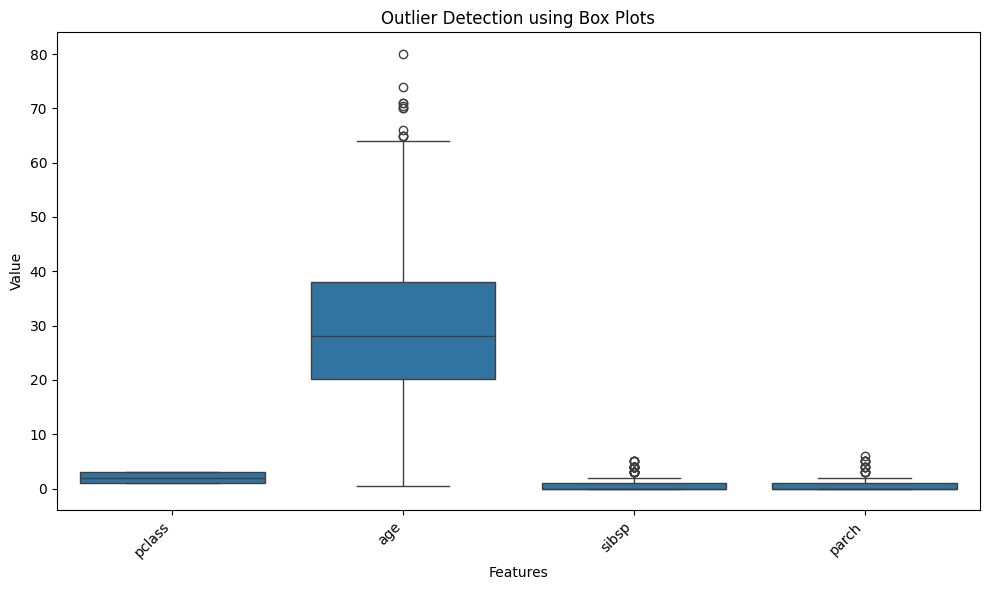

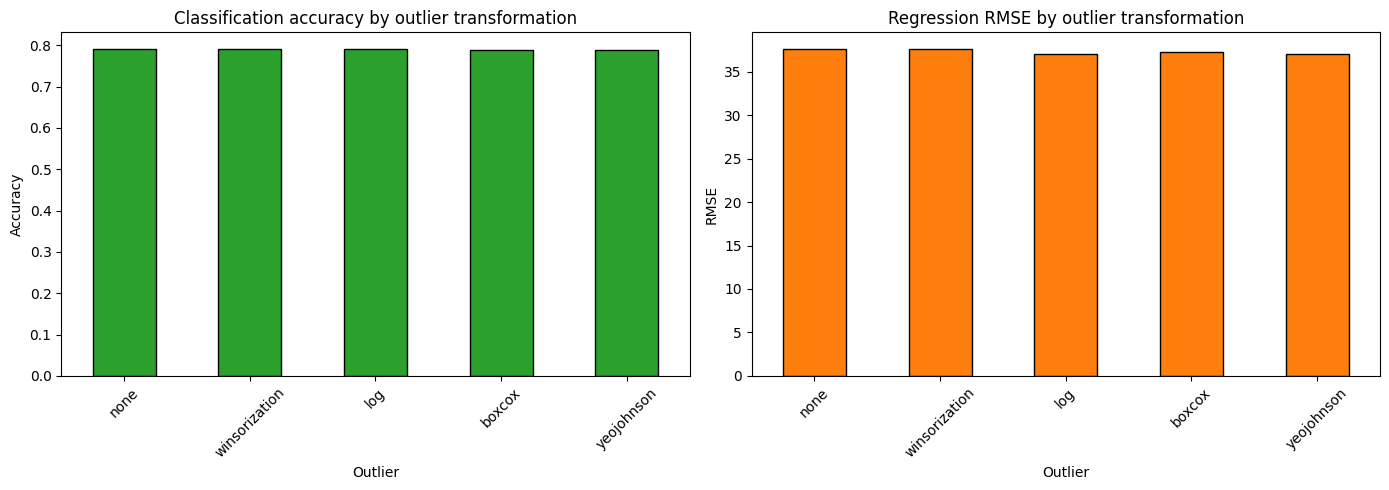

In [8]:
# Генерируем и показываем графики
lab1.plot_missingness(df, config)
lab1.plot_outlier_distributions(df, config)
lab1.plot_metric_comparison(classification_df, regression_df)
lab1.plot_correlation_heatmap(df, config)
lab1.plot_target_boxplot(df, config)
for path in sorted(Path("figures").glob("*.png")):
    display(Image(path))